# Autoencoder

차원축소 목적, feature extractor, generative model.
데이터를 효율적으로 representation하는 방법을 학습
1. Stacked Autoencoder
- 여러개의 hidden layer를 가진경우. 더 복잡한 표현을 학습. Hidden layer를 기준으로 Encoder와 Decoder가 대칭
- 완벽하게 대칭을 이룰경우, Encoder와 Decoder의 가중치를 묶어 훈련속도를 높이고 Overfitting 위험을 줄일 수 있다.
2. Denoising Autoencoder
- Stacked Autoencoder의 경우 hidden layer가 많으면 overfitting 가능성.
- Input에 noise를 주어 모델이 데이터 표현을 학습하기 힘들게 함.
3. LSTM Encoder
- 
4. Basic
* Encoder
    - 입력 x를 저차원 잠재 벡터 $z=f(x)$로 변환. 저차원이기 때문에 Encoder가 Input data에서 가장 중요한 특징만 학습함
* Decoder
    - 잠재 벡터 $g(z) = \tilde x$로 부터 입력 데이터를 복원.
    - Decoder는 $\tilde x$를 가능한 $x$에 가깝게 만드는 것을 목표로 함.

# Imports

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tensorboard

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Dataset, Preprocessing

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
image_size = x_train.shape[1]
print(x_train.shape)
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


# Hyperparameters

In [4]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

# Model

## Encoder

In [6]:
inputs = Input(shape = input_shape, name='encoder_input')
x = inputs
x = Conv2D(32, kernel_size = kernel_size, activation='relu', strides = 2, padding = 'same')(x)
x = Conv2D(64, kernel_size= kernel_size, activation='relu', strides=2, padding = 'same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

In [10]:
shape

(None, 7, 7, 64)

In [7]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


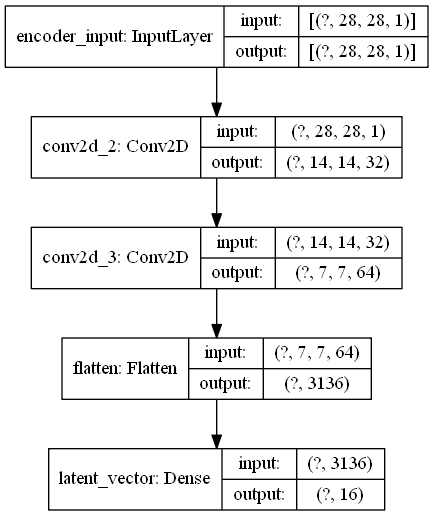

In [9]:
plot_model(encoder, show_shapes=True)

## Decoder

In [12]:
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters=64, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)

In [14]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

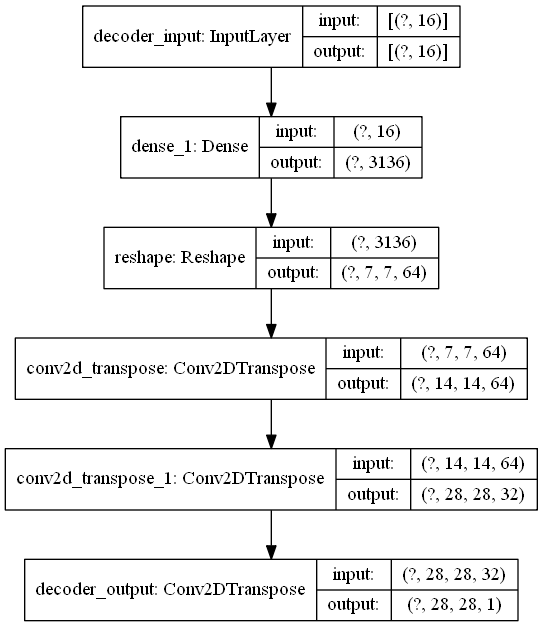

In [16]:
plot_model(decoder, show_shapes=True)

## Autoencoder

In [18]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


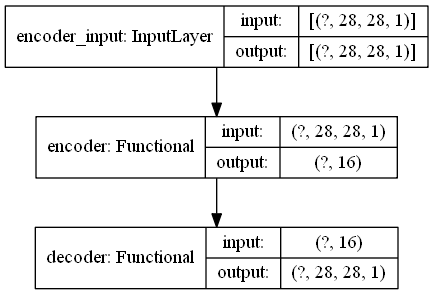

In [19]:
plot_model(autoencoder, show_shapes=True)

In [32]:
autoencoder.compile(loss='mse', optimizer='adam')

In [33]:
logdir = 'log/'+datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [34]:
autoencoder.fit(x_train, x_train, validation_data = (x_test, x_test), epochs=20, batch_size = batch_size, callbacks=[tensorboard_callback])

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.006

In [35]:
x_decoded = autoencoder.predict(x_test)

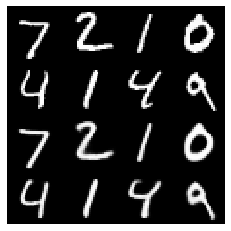

In [36]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()